In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import glob
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from itertools import combinations

In [2]:
forecast_demand_file_path = '../data/forecastdemand_nsw.csv'
actual_demand_file_path = '../data/totaldemand_nsw.csv'
temperature_file_path = '../data/temperature_nsw.csv'
forecast_demand = pd.read_csv(forecast_demand_file_path)
actual_demand = pd.read_csv(actual_demand_file_path)
temperature = pd.read_csv(temperature_file_path)

Exports_file_path = '../data/Exports - quarterly 2010-2023.csv'
GDP_file_path = '../data/GDP - quarterly 2010-2023.csv'
Interest_file_path = '../data/Interest rate - daily 2011-2023.csv'
SolarInstall_file_path = '../data/Solar installation number - monthly 2007-2023.csv'
SolarOutput_file_path = '../data/Solar outputs - monthly 2015-2023.csv'
Unemployment_file_path = '../data/Unemployment rate - monthly 2010-2023.csv'
Wholesale_file_path = '../data/Wholesale electricity price - half hourly 2014-2023.csv'
cpi_file_path = '../data/inflation-data.xls'
comm_file_path = '../data/Commodity prices index - monthly 2010-2023.csv'
rainfall_file_path = '../data/Rainfall - daily 2010-2023.csv'
weather_file_path = '../data/Weather - daily 2022-2023.csv'
SolarExposure_file_path = '../data/Solar exposure - daily 2010-2023.csv'

cpi = pd.read_excel(cpi_file_path)
Exports = pd.read_csv(Exports_file_path)
GDP = pd.read_csv(GDP_file_path)
Interest = pd.read_csv(Interest_file_path)
SolarInstall = pd.read_csv(SolarInstall_file_path)
SolarOutput = pd.read_csv(SolarOutput_file_path)
Unemployment = pd.read_csv(Unemployment_file_path)
Wholesale = pd.read_csv(Wholesale_file_path)
Comm = pd.read_csv(comm_file_path)
Rainfall = pd.read_csv(rainfall_file_path)
Weather = pd.read_csv(weather_file_path)
SolarExposure = pd.read_csv(SolarExposure_file_path)

In [3]:
path = '../data/nswdemand2022onwards'
all_files = glob.glob(os.path.join(path, "*.csv"))

total_demand_2022onwards = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

In [4]:
lag_value = -3
test_date = '2020-11-30'

In [5]:
temperature.loc[temperature['TEMPERATURE'] <= -5, 'TEMPERATURE'] = np.nan
df = pd.DataFrame({'Date Time': actual_demand['DATETIME'], 'Total Demand': actual_demand['TOTALDEMAND']})
df = pd.merge(df,temperature,left_on=['Date Time'], right_on=['DATETIME'], how = 'left')
df=df.drop(columns=['DATETIME', 'LOCATION'])
df['TEMPERATURE'] = df['TEMPERATURE'].interpolate(method='linear')
df['Date Time'] = pd.to_datetime(df['Date Time'])
forecast_demand['DATETIME'] = pd.to_datetime(forecast_demand['DATETIME'])
actual_demand['DATETIME'] = pd.to_datetime(actual_demand['DATETIME'])
forecast_demand['LASTCHANGED'] = pd.to_datetime(forecast_demand['LASTCHANGED'])
forecast_demand['TIME_DIFF'] = forecast_demand['DATETIME'] - forecast_demand['LASTCHANGED']
forecast_demand = forecast_demand[forecast_demand['TIME_DIFF'] >= pd.Timedelta(hours=6)]
forecast_demand = forecast_demand.drop(columns=['TIME_DIFF'])
fore = forecast_demand.set_index('DATETIME').resample('1H').mean()[['FORECASTDEMAND']]
actu = actual_demand.set_index('DATETIME').resample('1H').mean()[['TOTALDEMAND']]
merged_df = fore.join(actu).dropna()
merged_df['DIFF'] = merged_df.eval('TOTALDEMAND - FORECASTDEMAND')
merged_df['Demand_Previous'] = merged_df['TOTALDEMAND'].shift(periods=(-24))
merged_df['Demand_Lagged'] = merged_df['TOTALDEMAND'].shift(periods=(lag_value))
merged_df['Demand_Rolling'] = merged_df['Demand_Lagged'].rolling(window=720).mean()

temperature['DATETIME'] = pd.to_datetime(temperature['DATETIME'])
temp = temperature.set_index('DATETIME').resample('1H').mean()
temp['TEMPERATURE_lagged'] = temp['TEMPERATURE'].shift(periods=lag_value)
data = merged_df.merge(temp, left_index=True, right_index=True, how='inner')
data = data.drop(['LOCATION','TEMPERATURE', 'FORECASTDEMAND', 'DIFF'], axis=1)
df = data.dropna()

column_rename_mapping = {
    'G1 CONSUMER PRICE INFLATION': 'DATETIME',
    'Unnamed: 1': 'cpi'
}
cpi = cpi.rename(columns=column_rename_mapping)[10:].dropna().set_index('DATETIME')
min_date, max_date = data.index.min(), data.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
cpi.index = pd.to_datetime(cpi.index, format='%b-%Y')
cpi = cpi[(cpi.index >= min_date) & (cpi.index <= max_date)]
cpi = cpi.reindex(date_range).fillna(method='ffill')
cpi['CPI_lagged'] = cpi['cpi'].shift(periods=lag_value)
cpi = cpi[['CPI_lagged']]
df = pd.concat([df, cpi], axis=1).dropna()

column_rename_mapping = {
    'Date': 'DATETIME',
    'Exports of goods and services': 'Exports'
}
Exports = Exports.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date, max_date = data.index.min(), data.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
Exports.index = pd.to_datetime(Exports.index, format='%b-%Y')
Exports = Exports[(Exports.index >= min_date) & (Exports.index <= max_date)]
Exports = Exports.reindex(date_range).fillna(method='ffill')
Exports['Exports_lagged'] = Exports['Exports'].shift(periods=lag_value)
Exports = Exports[['Exports_lagged']]
df = pd.concat([df, Exports], axis=1).dropna()

column_rename_mapping = {
    'Date': 'DATETIME',
    'Real GDP': 'GDP'
}
GDP = GDP.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date, max_date = data.index.min(), data.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
GDP.index = pd.to_datetime(GDP.index, format='%b-%Y')
GDP = GDP[(GDP.index >= min_date) & (GDP.index <= max_date)]
GDP = GDP.reindex(date_range).fillna(method='ffill')
GDP['GDP_lagged'] = GDP['GDP'].shift(periods=lag_value)
GDP = GDP[['GDP_lagged']]
df = pd.concat([df, GDP], axis=1).dropna()

column_rename_mapping = {
    'Date': 'DATETIME',
    'Cash Rate Target': 'Interest'
}
Interest = Interest.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date, max_date = data.index.min(), data.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
Interest.index = pd.to_datetime(Interest.index)
Interest = Interest[(Interest.index >= min_date) & (Interest.index <= max_date)]
Interest = Interest.reindex(date_range).fillna(method='ffill')
Interest['Interest_lagged'] = Interest['Interest'].shift(periods=lag_value)
Interest = Interest[['Interest_lagged']]
df = pd.concat([df, Interest], axis=1).dropna()

column_rename_mapping = {
    "'Month'": 'DATETIME',
    'Cumulative Residential': 'Residential',
    'Cumulative Commercial': 'Commercial'
}
SolarInstall = SolarInstall.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date, max_date = data.index.min(), data.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
SolarInstall.index = pd.to_datetime(SolarInstall.index)
SolarInstall = SolarInstall[(SolarInstall.index >= min_date) & (SolarInstall.index <= max_date)]
SolarInstall = SolarInstall.reindex(date_range).fillna(method='ffill')
SolarInstall['Residential_lagged'] = SolarInstall['Residential'].shift(periods=lag_value)
SolarInstall['Commercial_lagged'] = SolarInstall['Commercial'].shift(periods=lag_value)
SolarInstall = SolarInstall[['Residential_lagged','Commercial_lagged']]
df = pd.concat([df, SolarInstall], axis=1).dropna()

column_rename_mapping = {
    "Date": 'DATETIME',
    'Output NSW': 'SolarOutput'
}
SolarOutput = SolarOutput.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date, max_date = data.index.min(), data.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
SolarOutput.index = pd.to_datetime(SolarOutput.index)
SolarOutput = SolarOutput[(SolarOutput.index >= min_date) & (SolarOutput.index <= max_date)]
SolarOutput = SolarOutput.reindex(date_range).fillna(method='ffill')
SolarOutput['SolarOutput_lagged'] = SolarOutput['SolarOutput'].shift(periods=lag_value)
SolarOutput = SolarOutput[['SolarOutput_lagged']]
df = pd.concat([df, SolarOutput], axis=1).dropna()

column_rename_mapping = {
    "Date": 'DATETIME',
    'Unemployment rate': 'Unemployment'
}
Unemployment = Unemployment.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date, max_date = data.index.min(), data.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
Unemployment.index = pd.to_datetime(Unemployment.index, format='%b-%Y')
Unemployment = Unemployment[(Unemployment.index >= min_date) & (Unemployment.index <= max_date)]
Unemployment = Unemployment.reindex(date_range).fillna(method='ffill')
Unemployment['Unemployment_lagged'] = Unemployment['Unemployment'].shift(periods=lag_value)
Unemployment = Unemployment[['Unemployment_lagged']]
df = pd.concat([df, Unemployment], axis=1).dropna()

column_rename_mapping = {
    "SETTLEMENTDATE": 'DATETIME',
    'RRP': 'Price'
}
Wholesale = Wholesale.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date, max_date = data.index.min(), data.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
Wholesale.index = pd.to_datetime(Wholesale.index, format='%Y/%m/%d %H:%M:%S')
Wholesale = Wholesale[(Wholesale.index >= min_date) & (Wholesale.index <= max_date)]
Wholesale = Wholesale.reindex(date_range).fillna(method='ffill')
Wholesale['Price_lagged'] = Wholesale['Price'].shift(periods=lag_value)
Wholesale = Wholesale[['Price_lagged']]
df = pd.concat([df, Wholesale], axis=1).dropna()

column_rename_mapping = {
    "Date": 'DATETIME',
    'Commodity prices ': 'CommPrice'
}
Comm = Comm.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date, max_date = data.index.min(), data.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
Comm.index = pd.to_datetime(Comm.index, format='%b-%Y')
Comm = Comm[(Comm.index >= min_date) & (Comm.index <= max_date)]
Comm = Comm.reindex(date_range).fillna(method='ffill')
Comm['CommPrice_lagged'] = Comm['CommPrice'].shift(periods=lag_value)
Comm = Comm[['CommPrice_lagged']]
df = pd.concat([df, Comm], axis=1).dropna()

column_rename_mapping = {
    'Rainfall amount (mm)': 'Rainfall'
}
Rainfall = Rainfall.rename(columns=column_rename_mapping).dropna()#.set_index('DATETIME')
Rainfall['DATETIME'] = pd.to_datetime(Rainfall[['Year', 'Month', 'Day']])
Rainfall['DATETIME'] -= pd.DateOffset(days=1)
Rainfall = Rainfall.drop(columns=['Year', 'Month', 'Day'])
min_datetime, max_datetime = Rainfall['DATETIME'].min(), Rainfall['DATETIME'].max()
date_range = pd.date_range(start=min_datetime, end=max_datetime, freq='H')
Rainfall = Rainfall.set_index('DATETIME').reindex(date_range)
Rainfall['Rainfall'] = Rainfall['Rainfall'].fillna(method='ffill')
df = pd.concat([df, Rainfall], axis=1).dropna()

column_rename_mapping = {
    'Daily global solar exposure (MJ/m*m)': 'SolarExposure'
}
SolarExposure = SolarExposure.rename(columns=column_rename_mapping).dropna()#.set_index('DATETIME')
SolarExposure['DATETIME'] = pd.to_datetime(SolarExposure[['Year', 'Month', 'Day']])
SolarExposure['DATETIME'] -= pd.DateOffset(days=1)
SolarExposure = SolarExposure.drop(columns=['Year', 'Month', 'Day'])
min_datetime, max_datetime = SolarExposure['DATETIME'].min(), SolarExposure['DATETIME'].max()
date_range = pd.date_range(start=min_datetime, end=max_datetime, freq='H')
SolarExposure = SolarExposure.set_index('DATETIME').reindex(date_range)
SolarExposure['SolarExposure'] = SolarExposure['SolarExposure'].fillna(method='ffill')
df = pd.concat([df, SolarExposure], axis=1).dropna()

df['HourOfDay'] = df.index.hour
# day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df['DayOfWeek'] = df.index.dayofweek#.map(day_mapping)
df['DayOfYear'] = df.index.dayofyear
df['IsWeekend'] = np.where((df['DayOfWeek'] == 5) | (df['DayOfWeek'] == 6), 1, 0)
# df = pd.get_dummies(df, columns=['HourOfDay'], prefix='Day')
# df = pd.get_dummies(df, columns=['DayOfWeek'], prefix='Day')
# df = pd.get_dummies(df, columns=['DayOfYear'], prefix='Year')

In [6]:
To_Z_Score = [
#  'Demand_Previous',
#  'Demand_Lagged',
#  'Demand_Rolling',
 'TEMPERATURE_lagged',
 'CPI_lagged',
 'Exports_lagged',
 'GDP_lagged',
 'Interest_lagged',
 'Residential_lagged',
 'Commercial_lagged',
 'SolarOutput_lagged',
 'Unemployment_lagged',
 'Price_lagged',
 'CommPrice_lagged',
 'Rainfall',
 'SolarExposure']

In [7]:
list(df.columns)

['TOTALDEMAND',
 'Demand_Previous',
 'Demand_Lagged',
 'Demand_Rolling',
 'TEMPERATURE_lagged',
 'CPI_lagged',
 'Exports_lagged',
 'GDP_lagged',
 'Interest_lagged',
 'Residential_lagged',
 'Commercial_lagged',
 'SolarOutput_lagged',
 'Unemployment_lagged',
 'Price_lagged',
 'CommPrice_lagged',
 'Rainfall',
 'SolarExposure',
 'HourOfDay',
 'DayOfWeek',
 'DayOfYear',
 'IsWeekend']

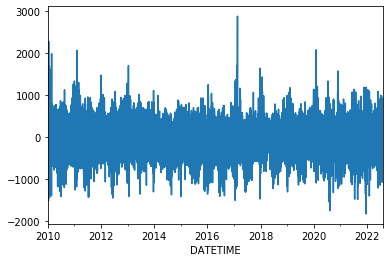

In [8]:
(forecast_demand.set_index('DATETIME').resample('1H').mean()['FORECASTDEMAND'] - actual_demand.set_index('DATETIME').resample('1H').mean()['TOTALDEMAND']).plot()

Evaluate the aemo model's performance

Mean Squared Error: 93038.16835459649
Root Mean Squared Error: 305.0215867026406
R-squared: 0.9461707823490928


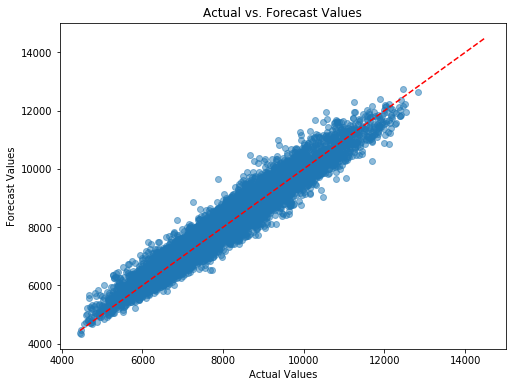

In [9]:
mse = mean_squared_error(merged_df['FORECASTDEMAND'], merged_df['TOTALDEMAND'])
r2 = r2_score(merged_df['FORECASTDEMAND'], merged_df['TOTALDEMAND'])
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

plt.figure(figsize=(8, 6))
plt.scatter(merged_df['FORECASTDEMAND'].loc[test_date:], merged_df['TOTALDEMAND'].loc[test_date:], alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Forecast Values")
plt.title("Actual vs. Forecast Values")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(merged_df['FORECASTDEMAND']), max(merged_df['FORECASTDEMAND'])], [min(merged_df['FORECASTDEMAND']), max(merged_df['FORECASTDEMAND'])], color='red', linestyle='--')

plt.show()

Evaluate the aemo model's performance (across testing period)

In [10]:
# Evaluate the aemo model's performance
mse = mean_squared_error(merged_df['FORECASTDEMAND'].loc[test_date:], merged_df['TOTALDEMAND'].loc[test_date:])
r2 = r2_score(merged_df['FORECASTDEMAND'].loc[test_date:], merged_df['TOTALDEMAND'].loc[test_date:])

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

Mean Squared Error: 96142.73431513214
Root Mean Squared Error: 310.0689186537924
R-squared: 0.9407544881212608


In [11]:
def calculate_r_squared(df, signal1, signal2, max_lag):
    result_df = pd.DataFrame(columns=['Lag', 'R-squared'])
    signal1 = df[signal1]
    signal2 = df[signal2]
    scaler = StandardScaler()
    for lag in range(-max_lag, 0 + 1):
        shifted_signal2 = np.roll(signal2, lag)
        signal1 = (signal1 - np.mean(signal1)) / (np.std(signal1) * len(signal1))
        shifted_signal2 = (shifted_signal2 - np.mean(shifted_signal2)) / (np.std(shifted_signal2) * len(signal1))
        r_squared = np.correlate(signal1, shifted_signal2, 'full')
        
#         r_squared = r2_score(z_score_signal1, z_score_shifted_signal2)
        result_df = result_df.append({'Lag': lag, 'R-squared': r_squared}, ignore_index=True)

    return result_df

In [12]:
# calculate_r_squared(df, 'TOTALDEMAND', 'TEMPERATURE_lagged', 10)

In [13]:
def run_regression_model(df, target, norm_columns, exclude_features=[]):
    feature_columns = [col for col in df.columns if col != target]
    feature_subset = [col for col in feature_columns if col not in exclude_features]
    print("Target: ", target)
    print("Features: ", feature_subset)
    
    keys = list(df.keys())
    norm_columns = [x for x in keys if x in norm_columns]

    df = df.dropna()

    train_data = df.loc[df.index <= test_date].copy()
    test_data = df.loc[df.index > test_date].copy()

    scaler = StandardScaler()
    train_data.loc[:, norm_columns] = scaler.fit_transform(train_data.loc[:, norm_columns])
    test_data.loc[:, norm_columns] = scaler.transform(test_data.loc[:, norm_columns])

    X_train, y_train = train_data[feature_subset], train_data[target]
    X_test, y_test = test_data[feature_subset], test_data[target]

    model = LinearRegression()

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {np.sqrt(mse)}")
    print(f"R-squared: {r2}")

    coefficients = model.coef_
    intercept = model.intercept_

    print("Coefficients:", coefficients)
    print("Intercept:", intercept)

    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs. Predicted Values")

    # Add a diagonal line for reference (perfect predictions)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

    plt.show()

Target:  TOTALDEMAND
Features:  ['Demand_Lagged', 'TEMPERATURE_lagged']
Mean Squared Error: 987606.3840194506
Root Mean Squared Error: 993.7838718853565
R-squared: 0.3727931958241555
Coefficients: [  0.65955118 -23.2612475 ]
Intercept: 2770.554724438116


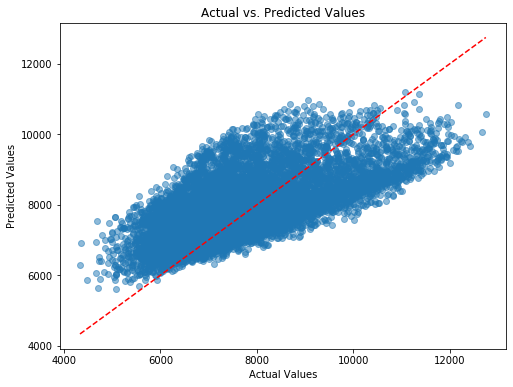

In [14]:
run_regression_model(data, 'TOTALDEMAND', norm_columns = To_Z_Score, exclude_features=['Demand_Previous','Demand_Rolling'])

Target:  TOTALDEMAND
Features:  ['Demand_Previous', 'Demand_Lagged', 'Demand_Rolling', 'TEMPERATURE_lagged']
Mean Squared Error: 331844.5475301622
Root Mean Squared Error: 576.0594999912441
R-squared: 0.7892529235255804
Coefficients: [931.97879784 301.63125886  46.45755271  11.04001616]
Intercept: 8137.631094685528


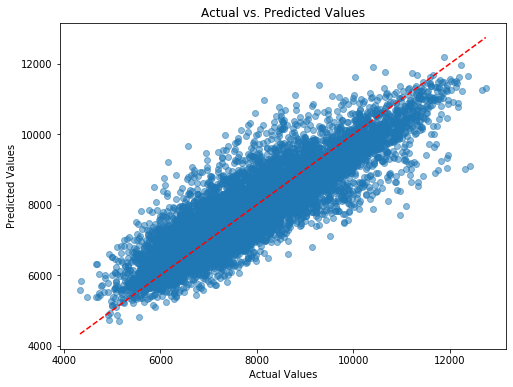

In [15]:
run_regression_model(data, 'TOTALDEMAND', norm_columns = ['Demand_Previous', 'Demand_Lagged', 'Demand_Rolling', 'TEMPERATURE_lagged'])

Target:  TOTALDEMAND
Features:  ['Demand_Previous', 'Demand_Lagged', 'Demand_Rolling', 'TEMPERATURE_lagged', 'CPI_lagged', 'Exports_lagged', 'GDP_lagged', 'Interest_lagged', 'Residential_lagged', 'Commercial_lagged', 'SolarOutput_lagged', 'Unemployment_lagged', 'Price_lagged', 'CommPrice_lagged', 'Rainfall', 'SolarExposure', 'HourOfDay', 'DayOfWeek', 'DayOfYear', 'IsWeekend']
Mean Squared Error: 333431.70845431817
Root Mean Squared Error: 577.4354582585989
R-squared: 0.7882449529949513
Coefficients: [ 6.06442083e-01  2.25249565e-01  1.92274775e-01  4.62561703e+01
  7.83729650e+01  1.61382268e+01 -1.07193191e+01  2.78826735e+01
 -1.64806424e+02  5.30696087e+01  6.70520364e+01  3.55949996e+01
  1.49969912e+01 -4.63745705e-01  1.31471988e+01 -8.55076826e+01
  3.03849467e+01  5.64458877e+01  2.77338845e-01 -5.17362352e+02]
Intercept: -615.9314287747775


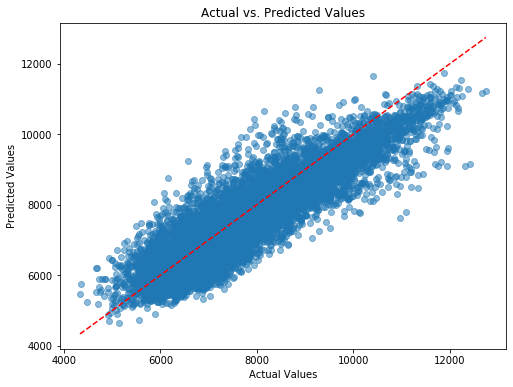

In [16]:
run_regression_model(df, 'TOTALDEMAND', norm_columns = To_Z_Score)

In [17]:
def run_xdg_model(_df, target, norm_columns, exclude_features=[], n_estimators=1500):
    feature_columns = [col for col in _df.columns if col != target]
    feature_subset = [col for col in feature_columns if col not in exclude_features]
    print("Target: ", target)
    print("Features: ", feature_subset)
    if exclude_features != []:
        print("Excluded Features: ", exclude_features)
    
    keys = list(_df.keys())
    norm_columns = [x for x in keys if x in norm_columns]

    _df = _df.dropna()

    train_data = _df.loc[_df.index <= test_date].copy()
    test_data = _df.loc[_df.index > test_date].copy()

    scaler = StandardScaler()
    train_data.loc[:, norm_columns] = scaler.fit_transform(train_data.loc[:, norm_columns])
    test_data.loc[:, norm_columns] = scaler.transform(test_data.loc[:, norm_columns])

    X_train, y_train = train_data[feature_subset], train_data[target]
    X_test, y_test = test_data[feature_subset], test_data[target]

    xgb_model = XGBRegressor(n_estimators=n_estimators, random_state=42)

    xgb_model.fit(X_train, y_train)

    y_pred = xgb_model.predict(X_test)

    mse, r2 = mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {np.sqrt(mse)}")
    print(f"R-squared: {r2}")
    
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs. Predicted Values")

    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

    plt.show()

Base Model

Target:  TOTALDEMAND
Features:  ['Demand_Lagged', 'TEMPERATURE_lagged']
Excluded Features:  ['Demand_Previous', 'Demand_Rolling']
Mean Squared Error: 1026609.7908774144
Root Mean Squared Error: 1013.2175437078724
R-squared: 0.34802300137908604


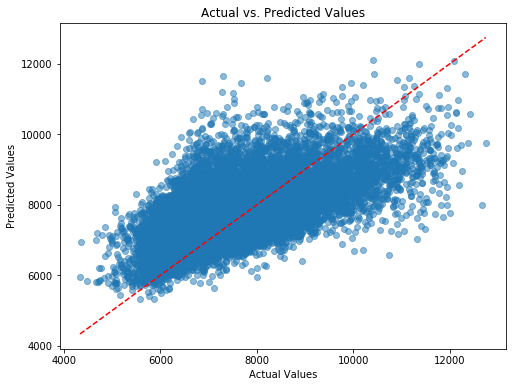

In [18]:
run_xdg_model(data, 'TOTALDEMAND', norm_columns = ['Demand_Lagged', 'TEMPERATURE_lagged'], exclude_features=['Demand_Previous','Demand_Rolling'], n_estimators=1500)

Target:  TOTALDEMAND
Features:  ['Demand_Previous', 'Demand_Lagged', 'Demand_Rolling', 'TEMPERATURE_lagged']
Mean Squared Error: 340313.91700347565
Root Mean Squared Error: 583.3643089900818
R-squared: 0.7838742157258981


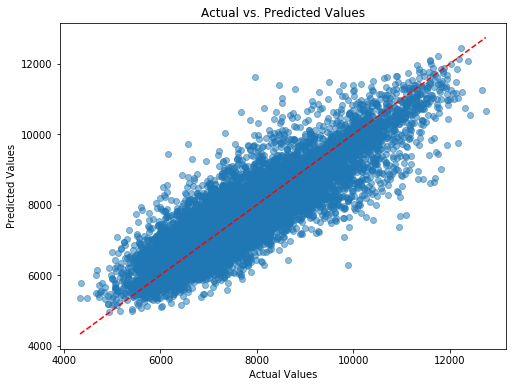

In [19]:
run_xdg_model(data, 'TOTALDEMAND', norm_columns = To_Z_Score, n_estimators=1500)

In [ ]:
run_xdg_model(df, 'TOTALDEMAND', norm_columns = To_Z_Score, exclude_features= [
                                                                               'CPI_lagged', 'Interest_lagged', 'CommPrice_lagged', 
#                                                                                'Exports_lagged', 'GDP_lagged',
#                                                                                'Residential_lagged', 'Commercial_lagged', 
#                                                                                 'SolarOutput_lagged',
#                                                                                'Unemployment_lagged', 'Price_lagged', 
#                                                                                 'Rainfall'
                                                                              ], n_estimators=2500)

Target:  TOTALDEMAND
Features:  ['Demand_Previous', 'Demand_Lagged', 'Demand_Rolling', 'TEMPERATURE_lagged', 'Exports_lagged', 'GDP_lagged', 'Residential_lagged', 'Commercial_lagged', 'SolarOutput_lagged', 'Unemployment_lagged', 'Price_lagged', 'Rainfall', 'SolarExposure', 'HourOfDay', 'DayOfWeek', 'DayOfYear', 'IsWeekend']
Excluded Features:  ['CPI_lagged', 'Interest_lagged', 'CommPrice_lagged']


Target:  TOTALDEMAND
Features:  ['Demand_Previous', 'Demand_Lagged', 'Demand_Rolling', 'TEMPERATURE_lagged', 'CPI_lagged', 'Exports_lagged', 'GDP_lagged', 'Interest_lagged', 'Residential_lagged', 'Commercial_lagged', 'SolarOutput_lagged', 'Unemployment_lagged', 'Price_lagged', 'CommPrice_lagged', 'Rainfall', 'SolarExposure', 'HourOfDay', 'DayOfWeek', 'DayOfYear', 'IsWeekend']
Mean Squared Error: 147902.48392999425
Root Mean Squared Error: 384.5809198725208
R-squared: 0.9060704286885474


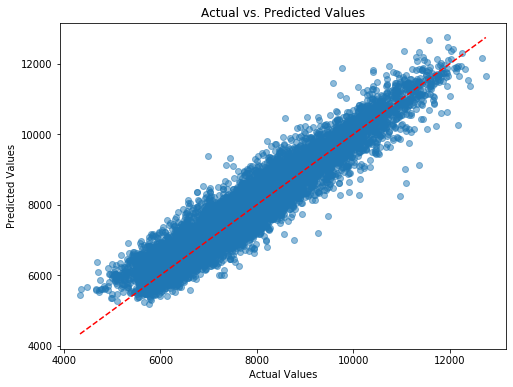

In [22]:
run_xdg_model(df,'TOTALDEMAND', norm_columns = To_Z_Score, n_estimators=3000)

In [23]:
for drop_features in list(df.keys()):
    run_xdg_model(df, 'TOTALDEMAND', To_Z_Score, exclude_features=[drop_features, ], n_estimators=3000)

Target:  TOTALDEMAND
Features:  ['Demand_Previous', 'Demand_Lagged', 'Demand_Rolling', 'TEMPERATURE_lagged', 'CPI_lagged', 'Exports_lagged', 'GDP_lagged', 'Interest_lagged', 'Residential_lagged', 'Commercial_lagged', 'SolarOutput_lagged', 'Unemployment_lagged', 'Price_lagged', 'CommPrice_lagged', 'Rainfall', 'SolarExposure', 'HourOfDay', 'DayOfWeek', 'DayOfYear', 'IsWeekend']
Excluded Features:  ['TOTALDEMAND']


KeyboardInterrupt: 